# K-means clustering
Create clusters (K-means) and visualize them.

Description of data https://www.kaggle.com/datasets/crawford/80-cereals?resource=download

In [1]:
import os

import sklearn.cluster as cluster
from sklearn.preprocessing import scale

import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_samples

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
def run_clusterings(df, cols_for_clustering, max_clusters=10, plot=True):
    inertia = []
    centroids_list = []
    n_clusters_list = list(range(1, max_clusters + 1))

    for n in n_clusters_list:
        km = cluster.KMeans(n_clusters=n)
        km = km.fit(df[cols_for_clustering])

        labels_col = f"labels_n={n}"
        df[labels_col] = km.labels_.astype("str")

        inertia.append(km.inertia_)
        centroids_list.append(km.cluster_centers_)

        if plot == True:
            print(f"Number of clusters {n}, Inertia: {km.inertia_:.2f}")
            scat = px.scatter(
                df,
                x=cols_for_clustering[0],
                y=cols_for_clustering[1],
                color=labels_col,
                symbol=labels_col,
            )
            scat.show()

    return df, inertia, centroids_list


def run_elbow_evaluation(max_clusters, inertia, plot=True):
    n_clusters_list = list(range(1, max_clusters + 1))

    df_eval = pd.DataFrame(data=inertia, index=n_clusters_list, columns=["inertia"])
    df_eval.index.name = "clusters"
    df_eval["improvement"] = -df_eval["inertia"].diff() / df_eval["inertia"].shift()

    if plot == True:
        scat = px.scatter(
            df_eval,
            x=df_eval.index,
            y="inertia",
        )
        scat.show()

        impro = px.scatter(df_eval, x=df_eval.index, y="improvement")
        impro.show()

    display(df_eval)

    return df_eval


def run_silhouette_analysis(df, cols_for_clustering, centroids_list, df_eval, SAN):
    average_scores = []

    #     # Reduce list of centroids for n_clusters for silhouette analysis
    #     san_centroids_list = centroids_list[0:4]

    for i, k in enumerate(SAN):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # Load labels and centroids for curren n_clusters
        labels_col = f"labels_n={k}"
        labels = df[labels_col]
        centroids = centroids_list[k - 1]

        # Get silhouette samples
        silhouette_vals = silhouette_samples(df[cols_for_clustering], labels)

        # Silhouette plot
        y_ticks = []
        y_lower, y_upper = 0, 0

        for i, clstr in enumerate(np.unique(labels)):
            cluster_silhouette_vals = silhouette_vals[labels == clstr]
            cluster_silhouette_vals.sort()
            y_upper += len(cluster_silhouette_vals)
            ax1.barh(
                range(y_lower, y_upper),
                cluster_silhouette_vals,
                edgecolor="none",
                height=1,
            )
            ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
            y_lower += len(cluster_silhouette_vals)

        # Get the average silhouette score and plot it
        avg_score = np.mean(silhouette_vals)
        average_scores.append(avg_score)

        ax1.axvline(avg_score, linestyle="--", linewidth=2, color="green")
        ax1.set_yticks([])
        ax1.set_xlim([-0.1, 1])
        ax1.set_xlabel("Silhouette coefficient values")
        ax1.set_ylabel("Cluster labels")
        ax1.set_title("Silhouette plot for the various clusters", y=1.02)

        # Scatter plot of data colored with labels
        ax2.scatter(
            df[cols_for_clustering[0]],
            df[cols_for_clustering[1]],
            c=df[labels_col].values.astype(int),
        )
        ax2.scatter(centroids[:, 0], centroids[:, 1], marker="*", c="r", s=250)
        ax2.set_xlim([-2, 2])
        ax2.set_xlim([-2, 2])
        ax2.set_xlabel(cols_for_clustering[0])
        ax2.set_ylabel(cols_for_clustering[1])
        ax2.set_title(
            f"{cols_for_clustering[0]}-{cols_for_clustering[1]} clusters", y=1.02
        )
        ax2.set_aspect("equal")
        plt.tight_layout()
        plt.suptitle(
            f"Silhouette analysis using k = {k}, silhouette average score = {avg_score:.3f}, inertia = {df_eval['inertia'].loc[k]:.1f}",
            fontsize=16,
            fontweight="semibold",
            y=1.05,
        )

    df_eval = pd.concat(
        [
            df_eval,
            pd.DataFrame(
                data=average_scores, index=SAN, columns=["silhouette avg score"]
            ),
        ],
        axis="columns",
    )

    return df_eval

<IPython.core.display.Javascript object>

In [3]:
DATA_FOLDER = "data"

<IPython.core.display.Javascript object>

In [4]:
df_all = pd.read_csv(os.path.join(DATA_FOLDER, "data_cereal.csv"))

<IPython.core.display.Javascript object>

## Content:
* Name: Name of cereal
* mfr: Manufacturer of cereal
    * A = American Home Food Products; G = General Mills; K = Kelloggs; N = Nabisco; P = Post; Q = Quaker Oats; R = Ralston Purina;
* type:
    * cold; hot
* calories: calories per serving
* protein: grams of protein
* fat: grams of fat
* sodium: milligrams of sodium
* fiber: grams of dietary fiber
* carbo: grams of complex carbohydrates
* sugars: grams of sugars
* potass: milligrams of potassium
* vitamins: vitamins and minerals - 0, 25, or 100, indicating the typical percentage of FDA recommended
* shelf: display shelf (1, 2, or 3, counting from the floor)
* weight: weight in ounces of one serving
* cups: number of cups in one serving
* rating: a rating of the cereals (Possibly from Consumer Reports?)

In [5]:
df_all.head()

name mfr type  calories  protein  fat  sodium  fiber  \
0                  100% Bran   N    C        70        4    1     130   10.0   
1          100% Natural Bran   Q    C       120        3    5      15    2.0   
2                   All-Bran   K    C        70        4    1     260    9.0   
3  All-Bran with Extra Fiber   K    C        50        4    0     140   14.0   
4             Almond Delight   R    C       110        2    2     200    1.0   

   carbo  sugars  potass  vitamins  shelf  weight  cups     rating  
0    5.0       6     280        25      3     1.0  0.33  68.402973  
1    8.0       8     135         0      3     1.0  1.00  33.983679  
2    7.0       5     320        25      3     1.0  0.33  59.425505  
3    8.0       0     330        25      3     1.0  0.50  93.704912  
4   14.0       8      -1        25      3     1.0  0.75  34.384843

<IPython.core.display.Javascript object>

In [6]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 16 columns):
name        77 non-null object
mfr         77 non-null object
type        77 non-null object
calories    77 non-null int64
protein     77 non-null int64
fat         77 non-null int64
sodium      77 non-null int64
fiber       77 non-null float64
carbo       77 non-null float64
sugars      77 non-null int64
potass      77 non-null int64
vitamins    77 non-null int64
shelf       77 non-null int64
weight      77 non-null float64
cups        77 non-null float64
rating      77 non-null float64
dtypes: float64(5), int64(8), object(3)
memory usage: 9.8+ KB


<IPython.core.display.Javascript object>

In [7]:
df_all.describe()

calories    protein        fat      sodium      fiber      carbo  \
count   77.000000  77.000000  77.000000   77.000000  77.000000  77.000000   
mean   106.883117   2.545455   1.012987  159.675325   2.151948  14.597403   
std     19.484119   1.094790   1.006473   83.832295   2.383364   4.278956   
min     50.000000   1.000000   0.000000    0.000000   0.000000  -1.000000   
25%    100.000000   2.000000   0.000000  130.000000   1.000000  12.000000   
50%    110.000000   3.000000   1.000000  180.000000   2.000000  14.000000   
75%    110.000000   3.000000   2.000000  210.000000   3.000000  17.000000   
max    160.000000   6.000000   5.000000  320.000000  14.000000  23.000000   

          sugars      potass    vitamins      shelf     weight       cups  \
count  77.000000   77.000000   77.000000  77.000000  77.000000  77.000000   
mean    6.922078   96.077922   28.246753   2.207792   1.029610   0.821039   
std     4.444885   71.286813   22.342523   0.832524   0.150477   0.232716   
min    -1.000000   -1.000000    0.000000   1.000000   0.500000   0.250000   
25%     3.000000   40.000000   25.000000   1.000000   1.000000   0.670000   
50%     7.000000   90.000000   25.000000   2.000000   1.000000   0.750000   
75%    11.000000  120.000000   25.000000   3.000000   1.000000   1.000000   
max    15.000000  330.000000  100.000000   3.000000   1.500000   1.500000   

          rating  
count  77.000000  
mean   42.665705  
std    14.047289  
min    18.042851  
25%    33.174094  
50%    40.400208  
75%    50.828392  
max    93.704912

<IPython.core.display.Javascript object>

In [8]:
delete_list = ["name", "mfr", "type"]
matrix_list = [item for item in list(df_all.columns) if item not in delete_list]

<IPython.core.display.Javascript object>

In [9]:
fig = px.scatter_matrix(
    df_all,
    dimensions=matrix_list,
)
fig.show()

<IPython.core.display.Javascript object>

In [10]:
for col in matrix_list:
    fig = px.scatter(df_all, x="rating", y=col)
    fig.show()

<IPython.core.display.Javascript object>

## Intro:
* minimization of inertia (within-cluster sum-of-squares criterion)
$$ \sum_{n=0}^{n} \min_{\mu_j \in C}(\|x-\mu_j\|^2) $$
* initiation of clusters:
    * random initial centroids 
    * k-means++ - distant initial centroids
* drawback
    * algo assumes convex, isotropic clusters, works poorly on irregular shapes of clusters
    * “curse of dimensionality” - Inertia is not a normalized metric, tends to become inflated in multiple dimensions $ \Rightarrow $ PCA

## Try out of K-means clustering
* perform clustering using two columns that are easy to cluster by eye - e.g. sugars x sodium
    * standardize columns
    * apply K-means with n_clusters decided by common sense
    * vizualize clusters

In [11]:
df_cluster = df_all.copy()
df_stnd = df_all.copy()

<IPython.core.display.Javascript object>

In [12]:
# Standardize numerical columns
num_cols = [
    col for col in df_stnd.columns if df_stnd[col].dtype in ["int64", "float64"]
]

df_stnd[num_cols] = df_stnd[num_cols].pipe(scale)

<IPython.core.display.Javascript object>

In [13]:
fig = px.scatter(df_cluster, x="sugars", y="sodium", title="Raw data")
fig.show()

fig = px.scatter(df_stnd, x="sugars", y="sodium", title="Standardized data")
fig.show()

<IPython.core.display.Javascript object>

In [14]:
# Apply Kmeans clustering with 3 clusters
km = cluster.KMeans(n_clusters=3)
km = km.fit(df_stnd[["sugars", "sodium"]])

df_stnd["cluster"] = km.labels_.astype("str")

if "cluster" in df_cluster.columns:
    if ~df_cluster["cluster"].equals(df_stnd["cluster"]):
        df_cluster["cluster"] = df_stnd["cluster"]
    else:
        pass
else:
    df_cluster = pd.concat([df_cluster, df_stnd["cluster"]], axis="columns")

<IPython.core.display.Javascript object>

In [15]:
fig = px.scatter(df_stnd, x="sugars", y="sodium", color="cluster")
fig.show()

<IPython.core.display.Javascript object>

## Evaluation of clustering
* run K-means clustering with n_clusters = 1-10
* evaluate the clusterings with
    * Elbow evaluation method
    * Silhouette Analysis
* choose the n_clusters with best performance

In [16]:
max_clusters = 10
cols_for_clustering = ["sugars", "sodium"]

df_stnd, inertia, centroids_list = run_clusterings(
    df_stnd,
    cols_for_clustering=cols_for_clustering,
    max_clusters=max_clusters,
    plot=True,
)

Number of clusters 1, Inertia: 154.00


Number of clusters 2, Inertia: 89.20


Number of clusters 3, Inertia: 44.03


Number of clusters 4, Inertia: 33.30


Number of clusters 5, Inertia: 26.08


Number of clusters 6, Inertia: 20.36


Number of clusters 7, Inertia: 16.62


Number of clusters 8, Inertia: 13.75


Number of clusters 9, Inertia: 11.47


Number of clusters 10, Inertia: 9.93


<IPython.core.display.Javascript object>

### Elbow evaluation method
* plot the inertia (within-cluster sum-of-squares criterion) vs number of clusters
$$ \sum_{n=0}^{n} \min_{\mu_j \in C}(\|x-\mu_j\|^2) $$
* additionaly, calculate improvement of inertia when compared to the previous number of clusters 

In [17]:
df_eval = run_elbow_evaluation(max_clusters=max_clusters, inertia=inertia, plot=True)

inertia  improvement
clusters                         
1         154.000000          NaN
2          89.202275     0.420764
3          44.034959     0.506347
4          33.300921     0.243762
5          26.075591     0.216971
6          20.361794     0.219124
7          16.623153     0.183611
8          13.754784     0.172553
9          11.472118     0.165954
10          9.926972     0.134687

<IPython.core.display.Javascript object>

### Silhouette Analysis
Helps to determine degree of separation between the clusters. For each sample:
* Compute the average distance from all data points in the same cluster (ai).
* Compute the average distance from all data points in the closest cluster (bi).
* Compute the silhouette coefficient:
$$ \frac{b_i-a_i}{\max{a_i,b_i)}} $$

The coefficient can take values in the interval [-1, 1]. It is:
* 0 –> the sample is very close to the neighboring clusters.
* 1 –> the sample is far away from the neighboring clusters.
* -1 –> the sample is assigned to the wrong clusters.

Well clustered datase has  silhouette average score well above 0.5.

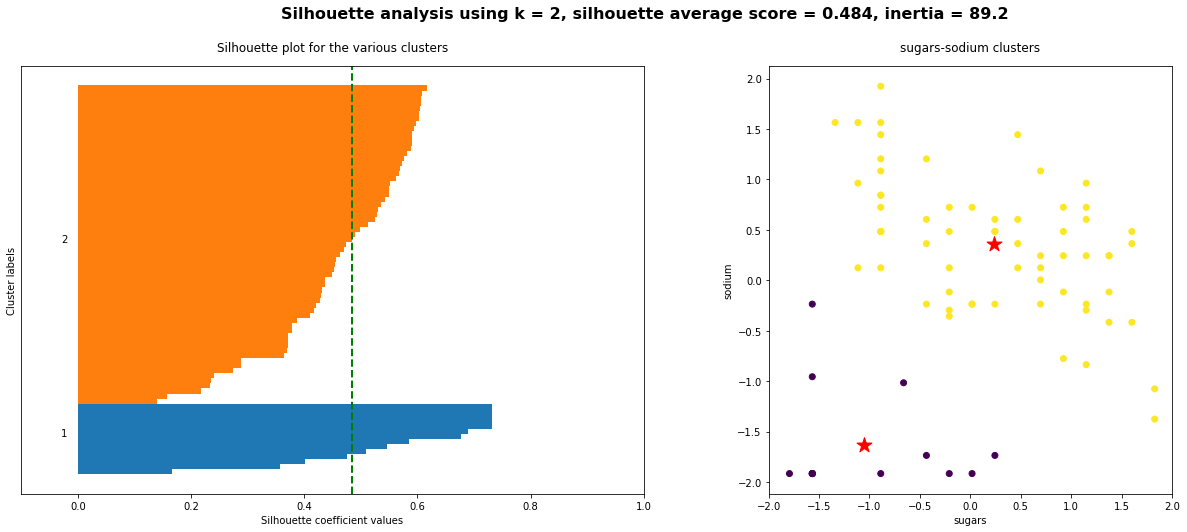

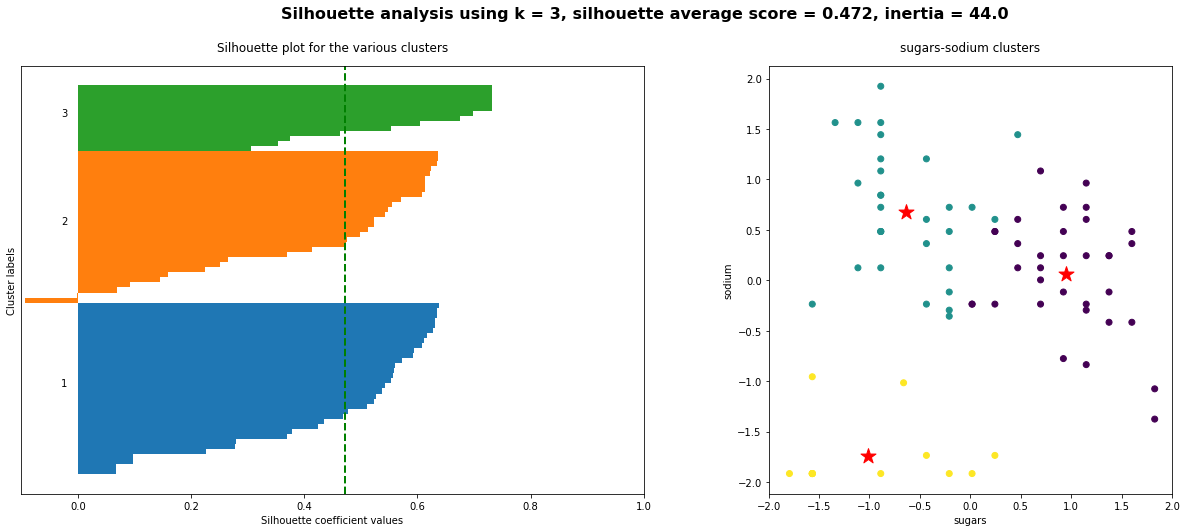

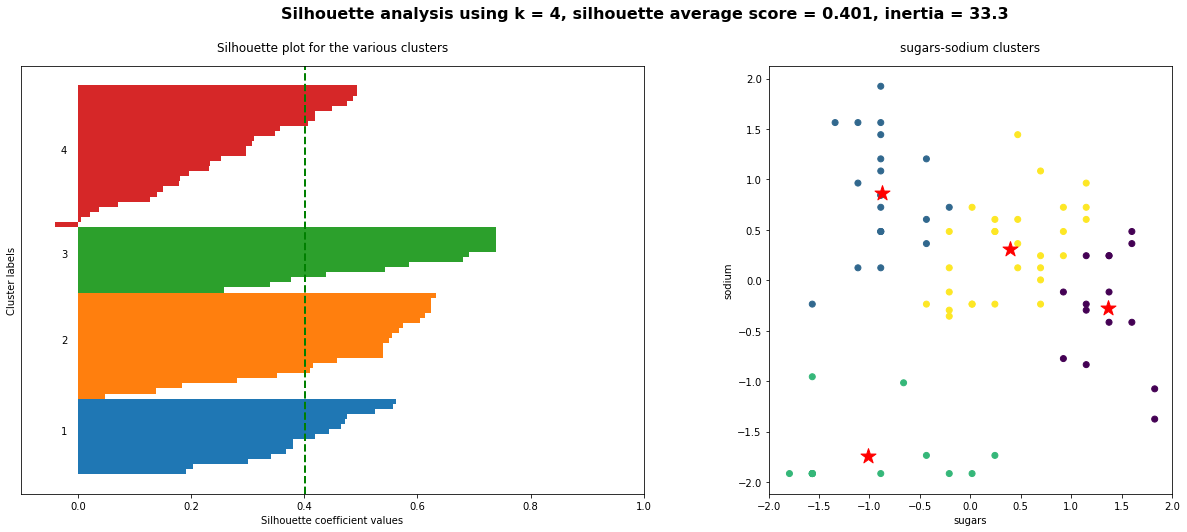

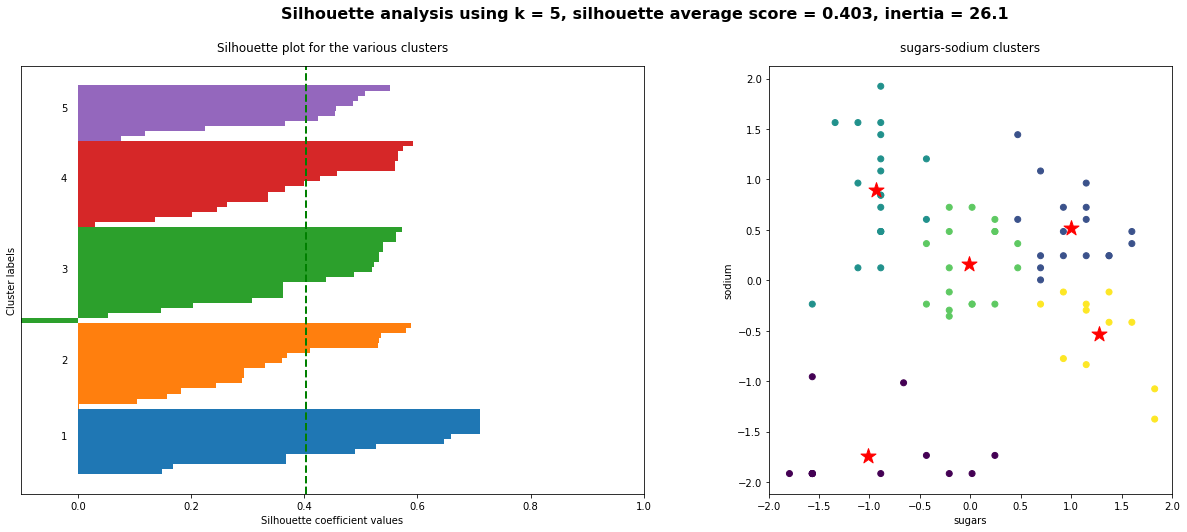

<IPython.core.display.Javascript object>

In [18]:
SAN = [2, 3, 4, 5]

df_eval = run_silhouette_analysis(
    df_stnd,
    cols_for_clustering,
    centroids_list=centroids_list,
    df_eval=df_eval,
    SAN=SAN,
)

## Multivariate K-means clustering

### Full data set

In [19]:
df_eval = pd.DataFrame()
df_mvc = df_all.copy()

num_cols = [col for col in df_mvc.columns if df_mvc[col].dtype in ["int64", "float64"]]
df_mvc[num_cols] = df_mvc[num_cols].pipe(scale)

<IPython.core.display.Javascript object>

In [20]:
max_clusters = 10
cols_for_clustering = num_cols

df_mvc, inertia, centroids_list = run_clusterings(
    df_mvc,
    cols_for_clustering=cols_for_clustering,
    max_clusters=max_clusters,
    plot=True,
)

Number of clusters 1, Inertia: 1001.00


Number of clusters 2, Inertia: 814.57


Number of clusters 3, Inertia: 672.71


Number of clusters 4, Inertia: 582.14


Number of clusters 5, Inertia: 490.24


Number of clusters 6, Inertia: 434.30


Number of clusters 7, Inertia: 396.46


Number of clusters 8, Inertia: 349.95


Number of clusters 9, Inertia: 317.95


Number of clusters 10, Inertia: 289.88


<IPython.core.display.Javascript object>

In [21]:
df_eval = run_elbow_evaluation(max_clusters=max_clusters, inertia=inertia, plot=True)

inertia  improvement
clusters                          
1         1001.000000          NaN
2          814.567767     0.186246
3          672.707465     0.174154
4          582.144897     0.134624
5          490.241159     0.157871
6          434.304571     0.114100
7          396.462964     0.087131
8          349.949474     0.117321
9          317.951452     0.091436
10         289.879490     0.088290

<IPython.core.display.Javascript object>

inertia  improvement  silhouette avg score
1   1001.000000          NaN                   NaN
2    814.567767     0.186246              0.185267
3    672.707465     0.174154              0.209542
4    582.144897     0.134624              0.211027
5    490.241159     0.157871              0.245545
6    434.304571     0.114100              0.262124
7    396.462964     0.087131              0.281742
8    349.949474     0.117321              0.298005
9    317.951452     0.091436              0.299035
10   289.879490     0.088290              0.302950

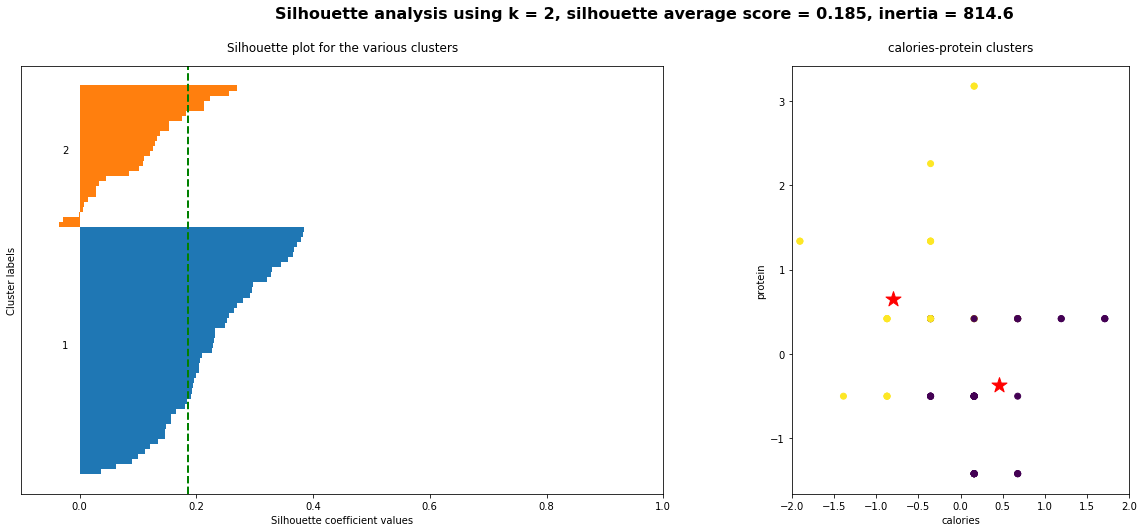

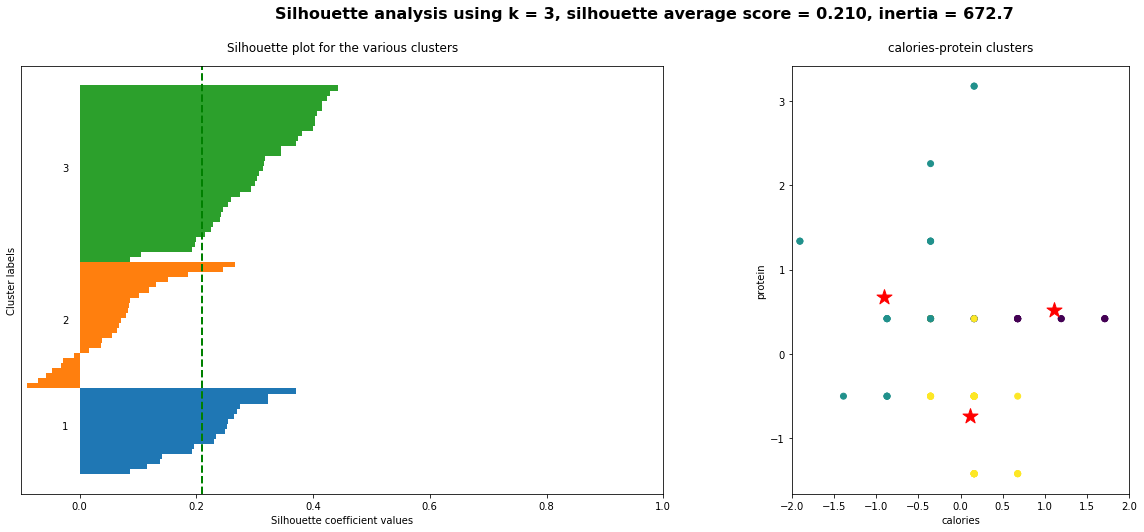

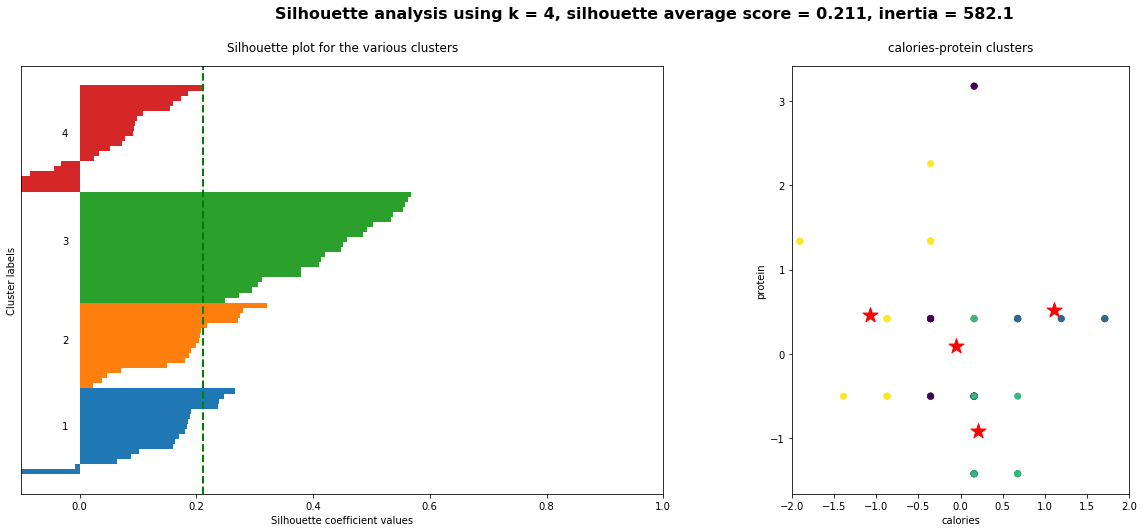

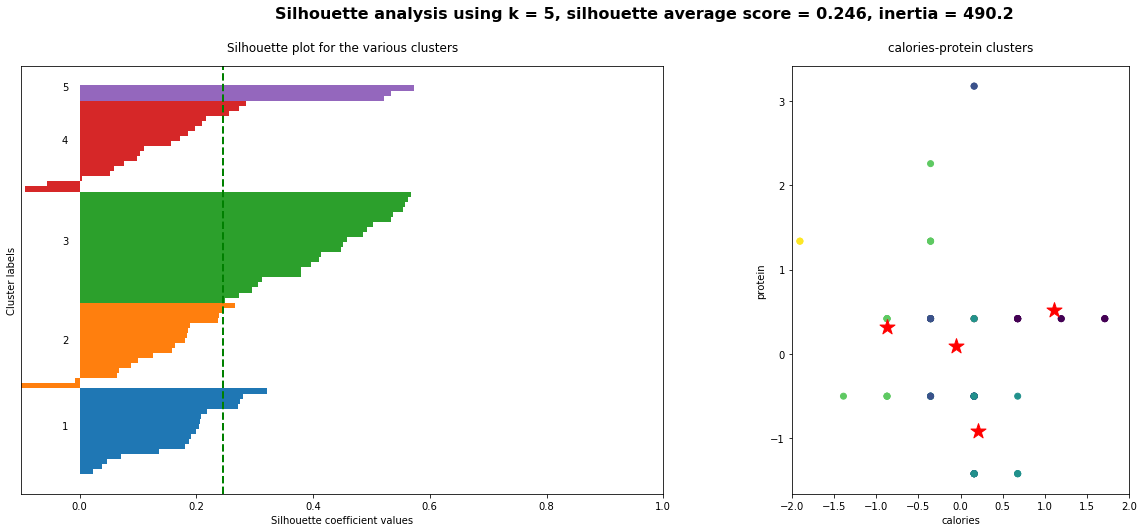

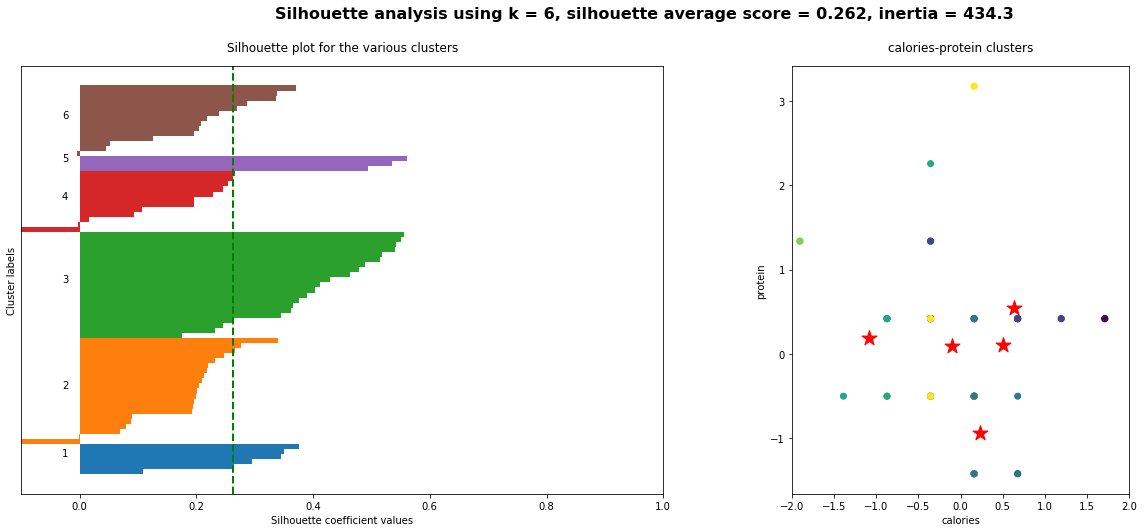

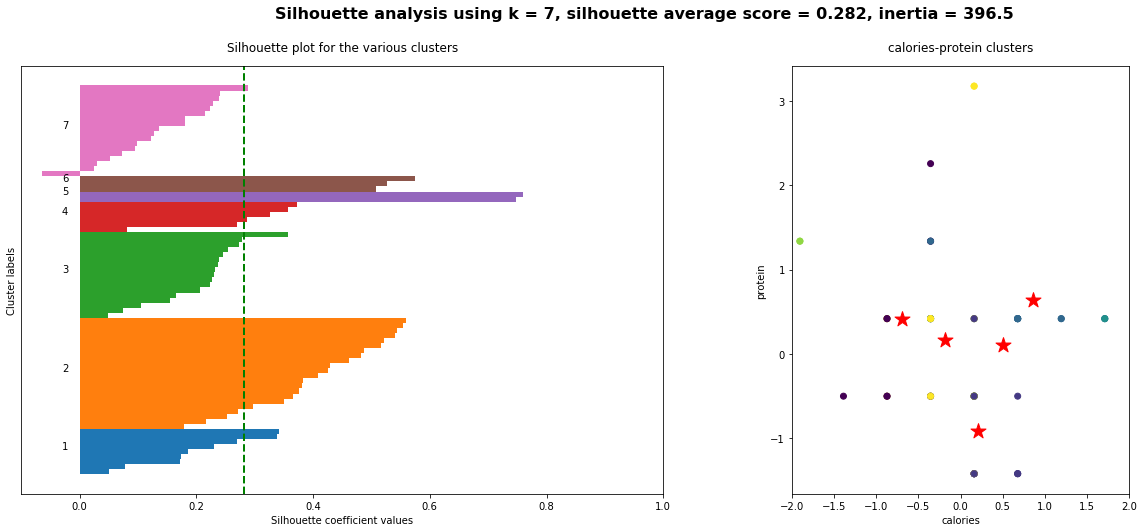

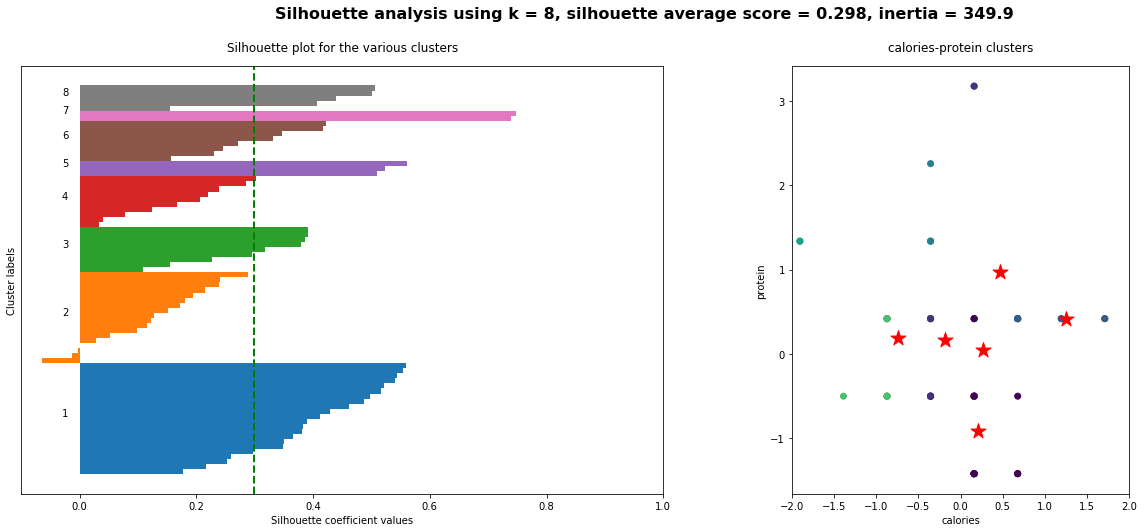

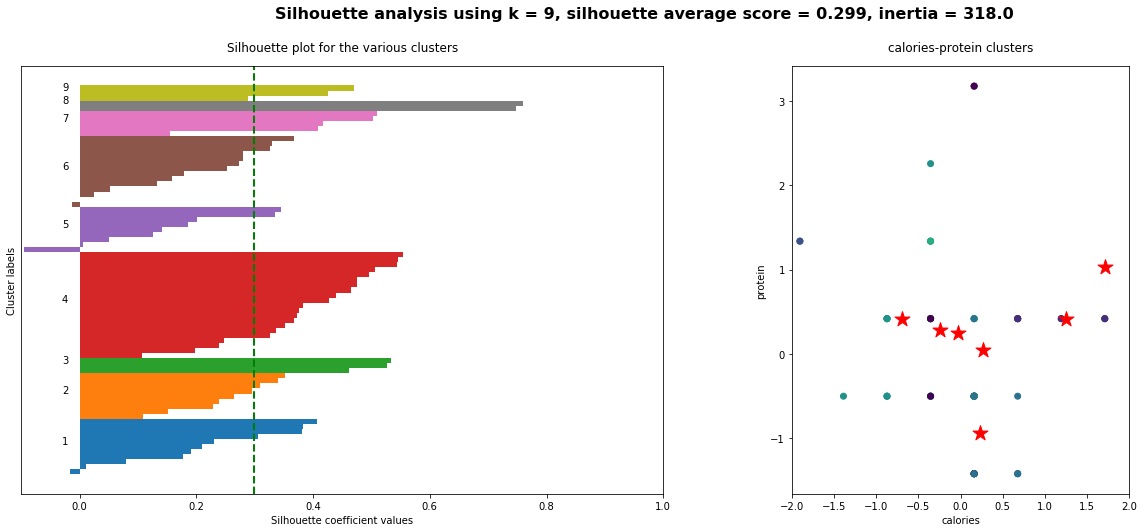

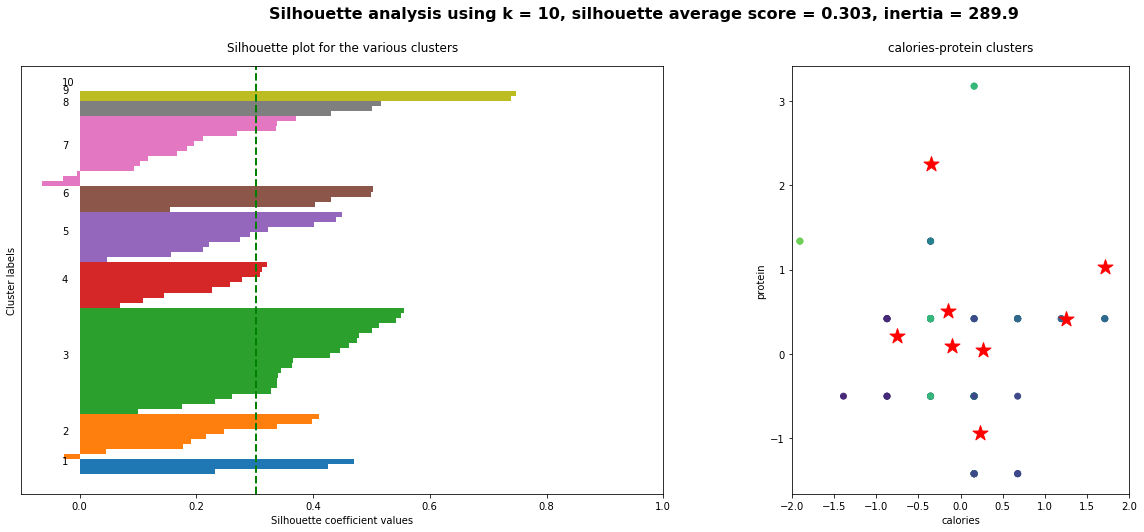

<IPython.core.display.Javascript object>

In [22]:
SAN = [2, 3, 4, 5, 6, 7, 8, 9, 10]

df_eval = run_silhouette_analysis(
    df_mvc,
    cols_for_clustering,
    centroids_list=centroids_list,
    df_eval=df_eval,
    SAN=SAN,
)

df_eval

### Reduced dimensionality, n_components = 8

In [23]:
from sklearn.decomposition import PCA

<IPython.core.display.Javascript object>

In [24]:
n_comp = 8
df_red8 = pd.DataFrame(
    data=PCA(n_components=n_comp).fit_transform(df_mvc[num_cols]),
    columns=[f"PC{i}" for i in list(range(1, n_comp + 1))],
)

df_red8

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0   5.529765 -1.805980 -0.613703 -1.131758 -0.875988  0.951639  0.118136   
1   0.262997 -1.810757 -3.095078  1.846356  2.470918  0.481391  0.650141   
2   4.893527 -2.091762  0.204152 -1.071774 -1.259489  1.902240 -0.652682   
3   7.737473 -0.667950  1.172466 -1.404438 -1.373020  0.835324  0.540065   
4  -1.146427 -0.215820 -0.736076 -0.361809  1.024117  0.409245 -0.995472   
..       ...       ...       ...       ...       ...       ...       ...   
72 -0.947976  0.526199  1.153025 -0.273628  0.895087 -0.016599 -1.710099   
73 -2.102265  0.537534 -1.362032 -0.601460 -0.276307 -0.161588  0.359935   
74  0.726308  0.599711  0.900750  0.948357 -0.880354  0.678708 -0.798526   
75  0.449448  1.055519  0.984321  1.194254 -0.635025  0.621373  0.306092   
76 -1.082958  0.592464 -0.194723  0.495844 -0.921950  0.241289 -0.543713   

         PC8  
0   0.052132  
1  -1.337862  
2  -0.343469  
3  -1.008243  
4  -0.088402  
..       ...  
72 -0.471058  
73 -0.259601  
74  0.527309  
75 -0.185279  
76  0.573414  

[77 rows x 8 columns]

<IPython.core.display.Javascript object>

In [25]:
max_clusters = 10
cols_for_clustering = df_red8.columns

df_red8, inertia, centroids_list = run_clusterings(
    df_red8,
    cols_for_clustering=cols_for_clustering,
    max_clusters=max_clusters,
    plot=True,
)

Number of clusters 1, Inertia: 957.77


Number of clusters 2, Inertia: 773.77


Number of clusters 3, Inertia: 630.88


Number of clusters 4, Inertia: 533.70


Number of clusters 5, Inertia: 447.84


Number of clusters 6, Inertia: 390.05


Number of clusters 7, Inertia: 347.36


Number of clusters 8, Inertia: 304.42


Number of clusters 9, Inertia: 289.15


Number of clusters 10, Inertia: 260.11


<IPython.core.display.Javascript object>

In [26]:
df_eval = run_elbow_evaluation(max_clusters=max_clusters, inertia=inertia, plot=True)

inertia  improvement
clusters                         
1         957.773861          NaN
2         773.767987     0.192118
3         630.883877     0.184660
4         533.704647     0.154037
5         447.837831     0.160888
6         390.052429     0.129032
7         347.355237     0.109465
8         304.415142     0.123620
9         289.145704     0.050160
10        260.110567     0.100417

<IPython.core.display.Javascript object>

inertia  improvement  silhouette avg score
1   957.773861          NaN                   NaN
2   773.767987     0.192118              0.216454
3   630.883877     0.184660              0.221266
4   533.704647     0.154037              0.248649
5   447.837831     0.160888              0.263099
6   390.052429     0.129032              0.280833
7   347.355237     0.109465              0.297178
8   304.415142     0.123620              0.315757
9   289.145704     0.050160              0.313270
10  260.110567     0.100417              0.317673

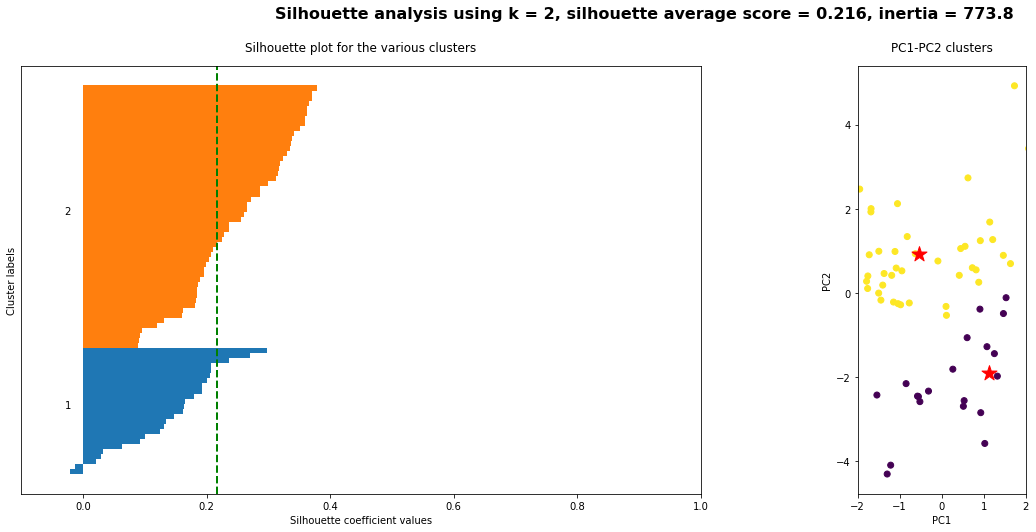

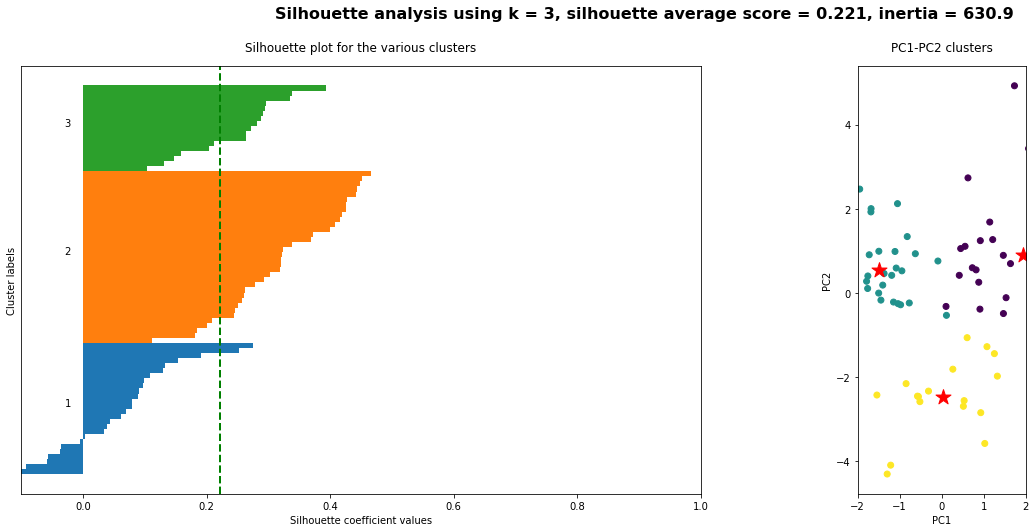

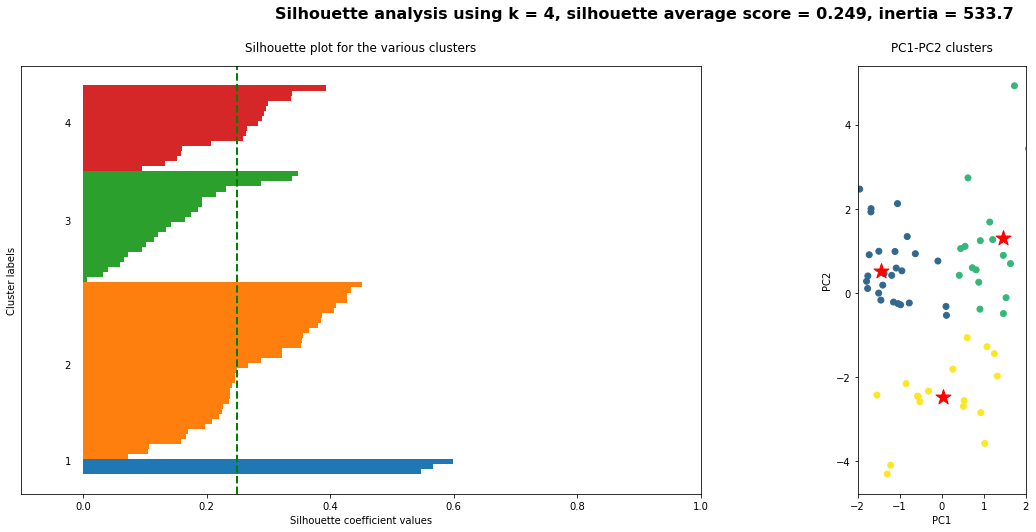

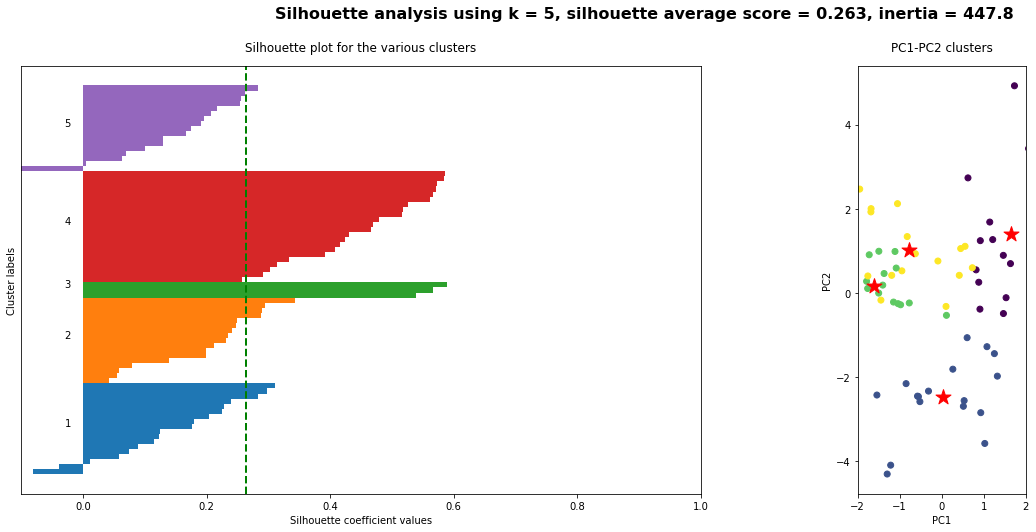

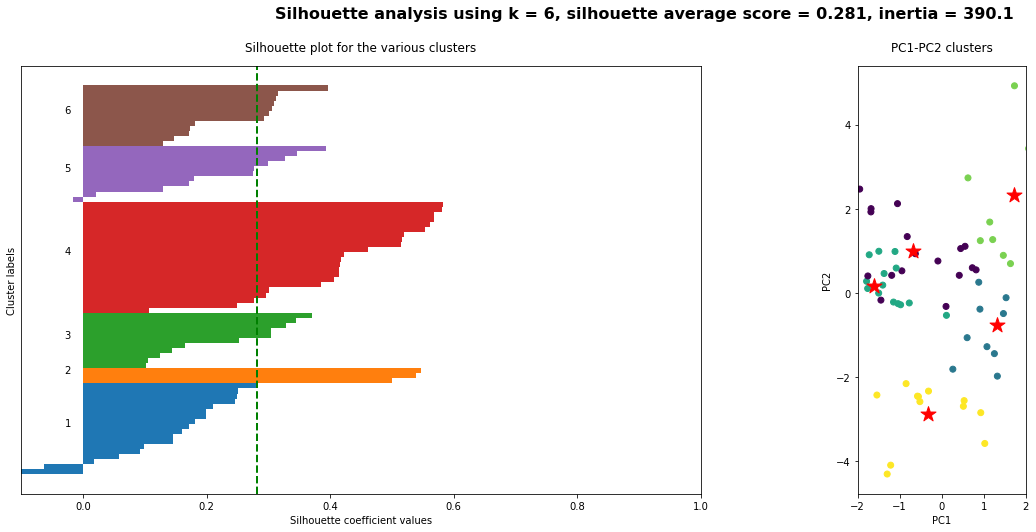

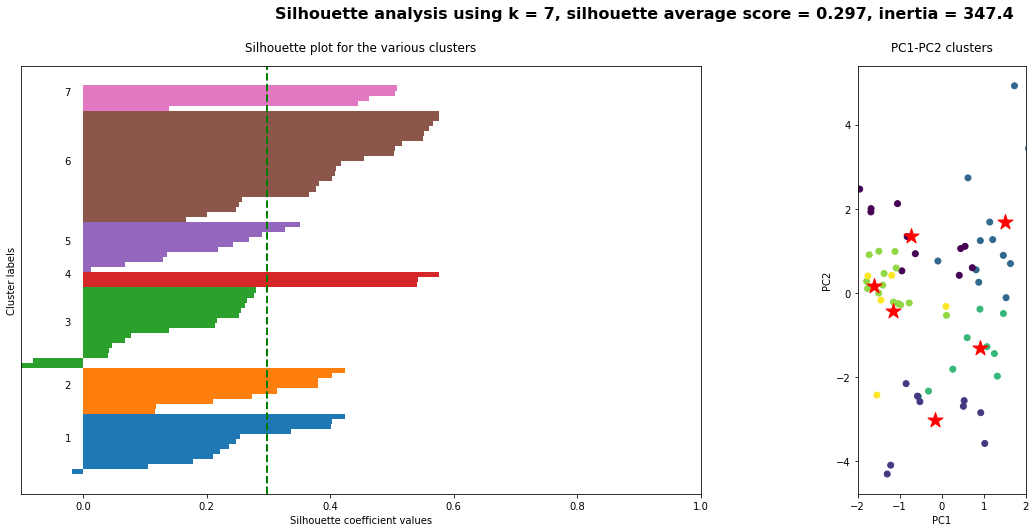

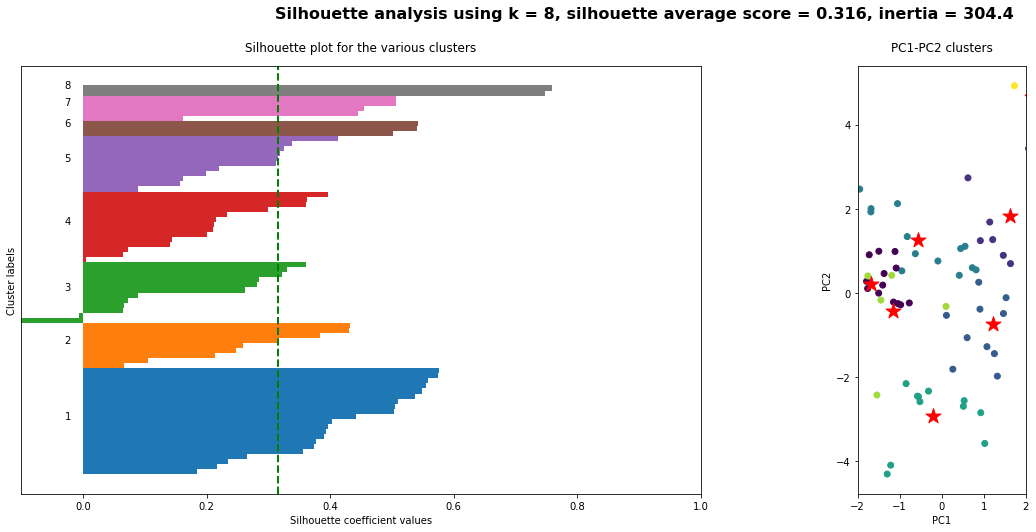

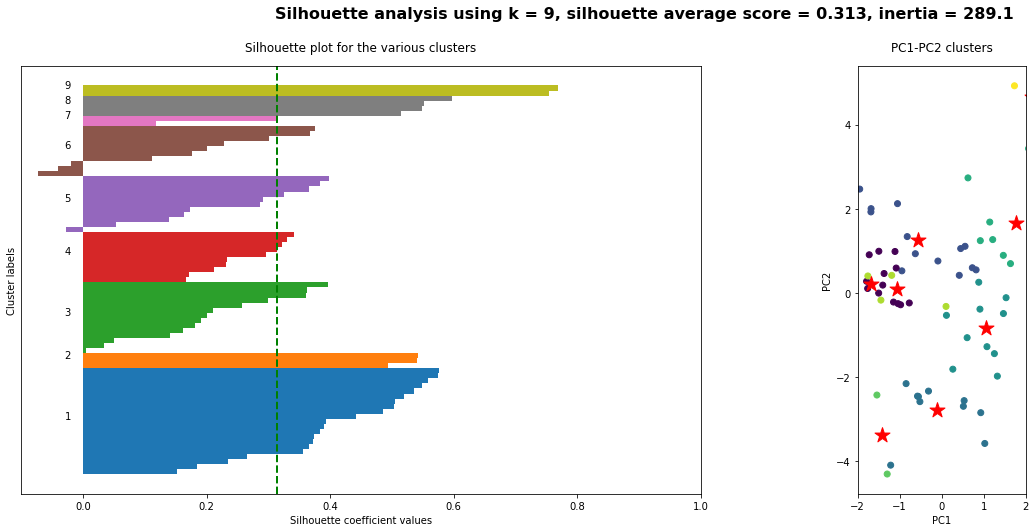

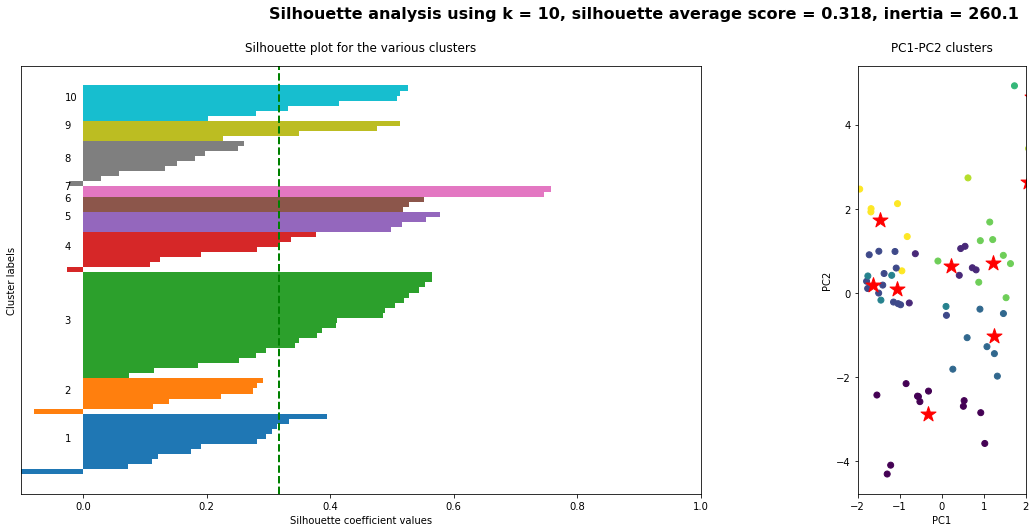

<IPython.core.display.Javascript object>

In [27]:
SAN = [2, 3, 4, 5, 6, 7, 8, 9, 10]

df_eval = run_silhouette_analysis(
    df_red8,
    cols_for_clustering,
    centroids_list=centroids_list,
    df_eval=df_eval,
    SAN=SAN,
)

df_eval

### Reduced dimensionality, n_components = 4

In [29]:
n_comp = 4
df_red4 = pd.DataFrame(
    data=PCA(n_components=n_comp).fit_transform(df_mvc[num_cols]),
    columns=[f"PC{i}" for i in list(range(1, n_comp + 1))],
)

df_red4

PC1       PC2       PC3       PC4
0   5.529765 -1.805980 -0.613703 -1.131758
1   0.262997 -1.810757 -3.095078  1.846356
2   4.893527 -2.091762  0.204152 -1.071774
3   7.737473 -0.667950  1.172466 -1.404438
4  -1.146427 -0.215820 -0.736076 -0.361809
..       ...       ...       ...       ...
72 -0.947976  0.526199  1.153025 -0.273628
73 -2.102265  0.537534 -1.362032 -0.601460
74  0.726308  0.599711  0.900750  0.948357
75  0.449448  1.055519  0.984321  1.194254
76 -1.082958  0.592464 -0.194723  0.495844

[77 rows x 4 columns]

<IPython.core.display.Javascript object>

In [30]:
max_clusters = 10
cols_for_clustering = df_red4.columns

df_red4, inertia, centroids_list = run_clusterings(
    df_red4,
    cols_for_clustering=cols_for_clustering,
    max_clusters=max_clusters,
    plot=True,
)

Number of clusters 1, Inertia: 741.31


Number of clusters 2, Inertia: 559.41


Number of clusters 3, Inertia: 424.32


Number of clusters 4, Inertia: 345.57


Number of clusters 5, Inertia: 265.64


Number of clusters 6, Inertia: 221.89


Number of clusters 7, Inertia: 185.81


Number of clusters 8, Inertia: 161.61


Number of clusters 9, Inertia: 143.32


Number of clusters 10, Inertia: 127.20


<IPython.core.display.Javascript object>

In [31]:
df_eval = run_elbow_evaluation(max_clusters=max_clusters, inertia=inertia, plot=True)

inertia  improvement
clusters                         
1         741.306627          NaN
2         559.414965     0.245366
3         424.323622     0.241487
4         345.566883     0.185605
5         265.642462     0.231285
6         221.885948     0.164720
7         185.810433     0.162586
8         161.611573     0.130234
9         143.320058     0.113182
10        127.195982     0.112504

<IPython.core.display.Javascript object>

inertia  improvement  silhouette avg score
1   741.306627          NaN                   NaN
2   559.414965     0.245366              0.270187
3   424.323622     0.241487              0.292729
4   345.566883     0.185605              0.312660
5   265.642462     0.231285              0.355340
6   221.885948     0.164720              0.380234
7   185.810433     0.162586              0.382986
8   161.611573     0.130234              0.379727
9   143.320058     0.113182              0.384240
10  127.195982     0.112504              0.404355

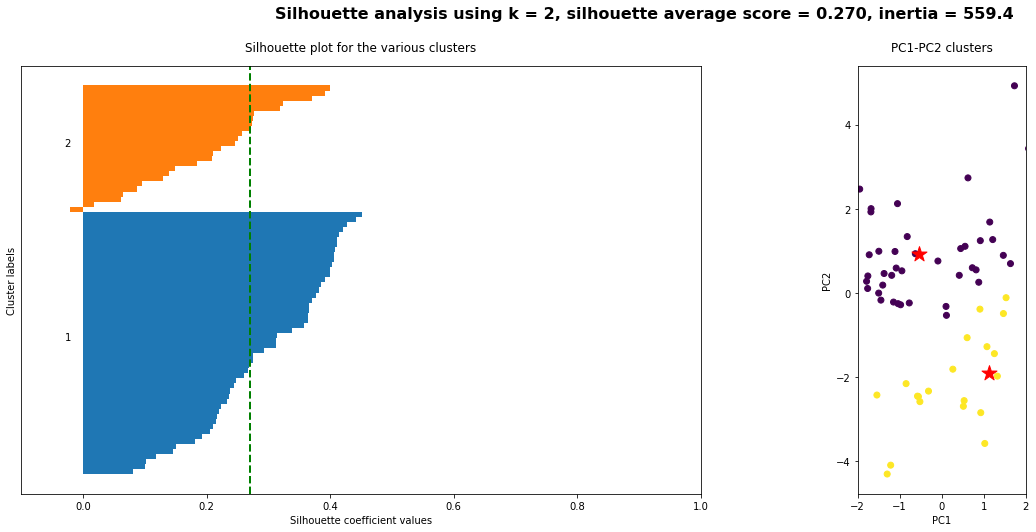

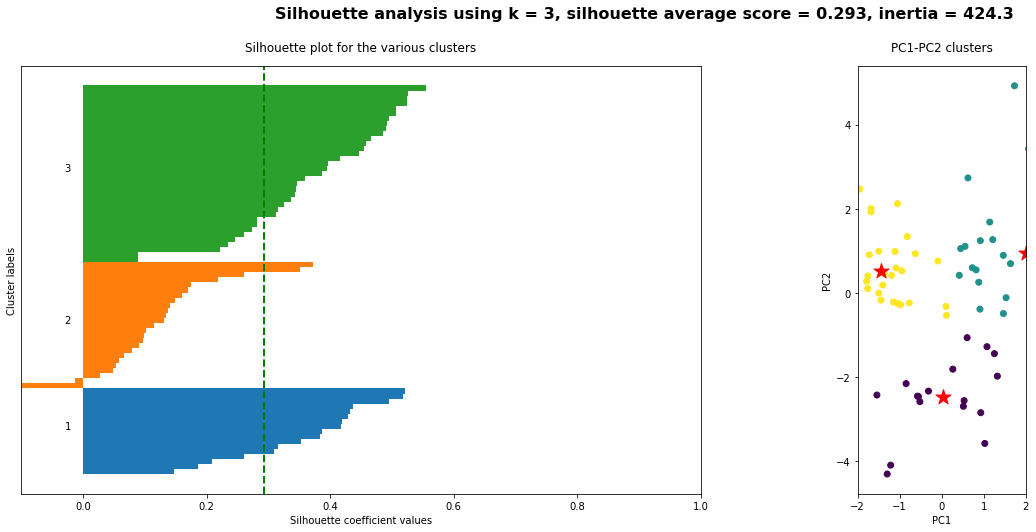

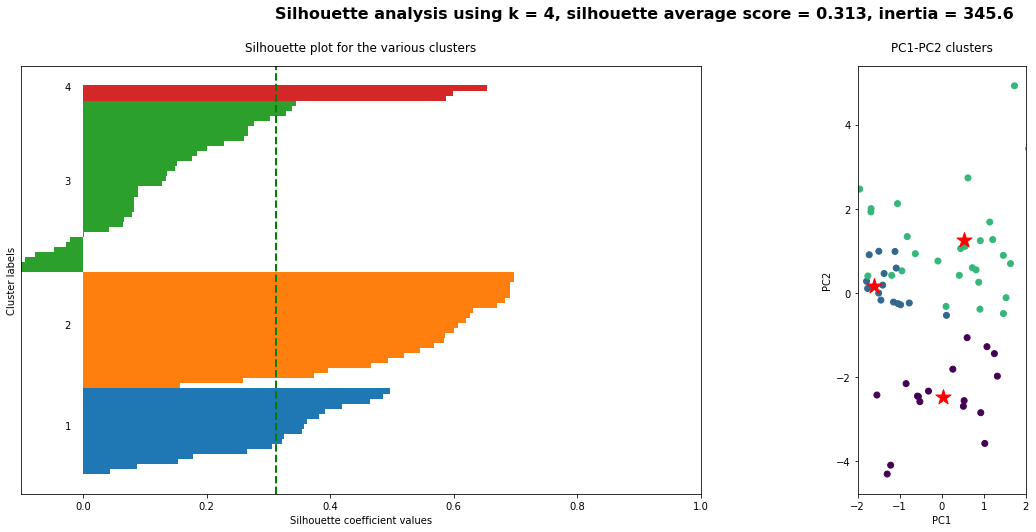

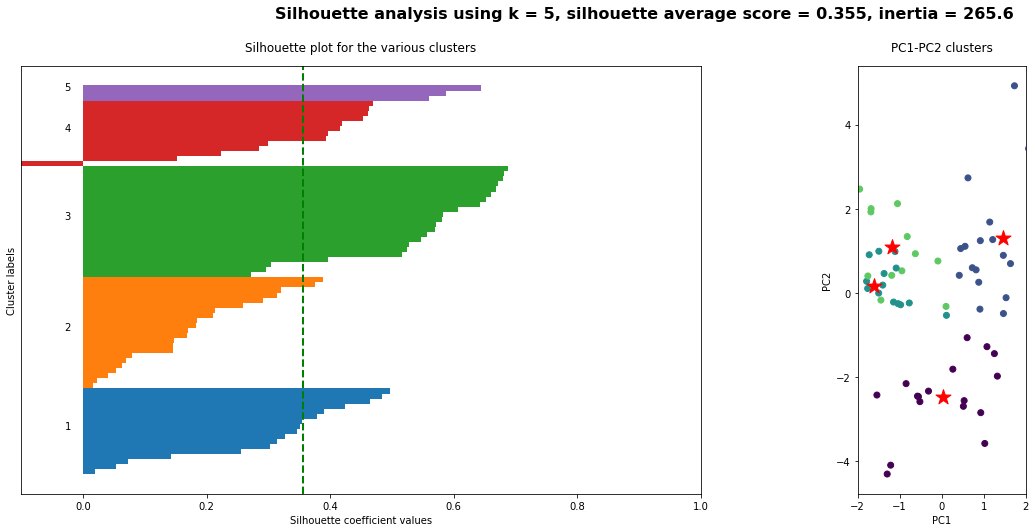

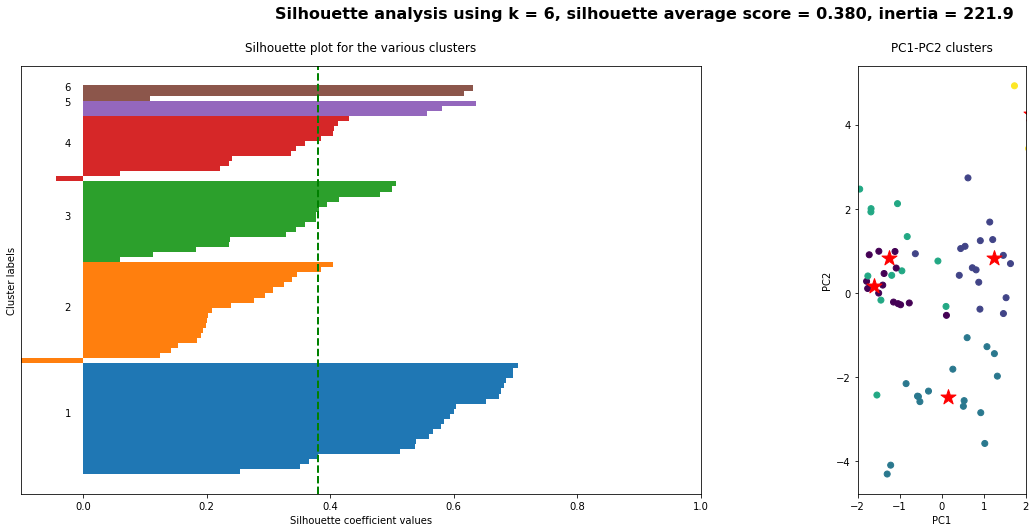

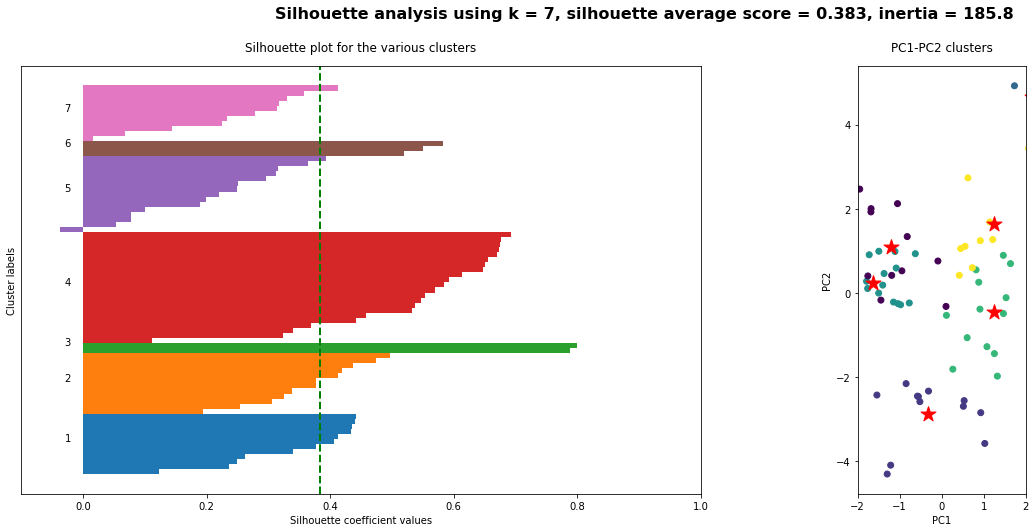

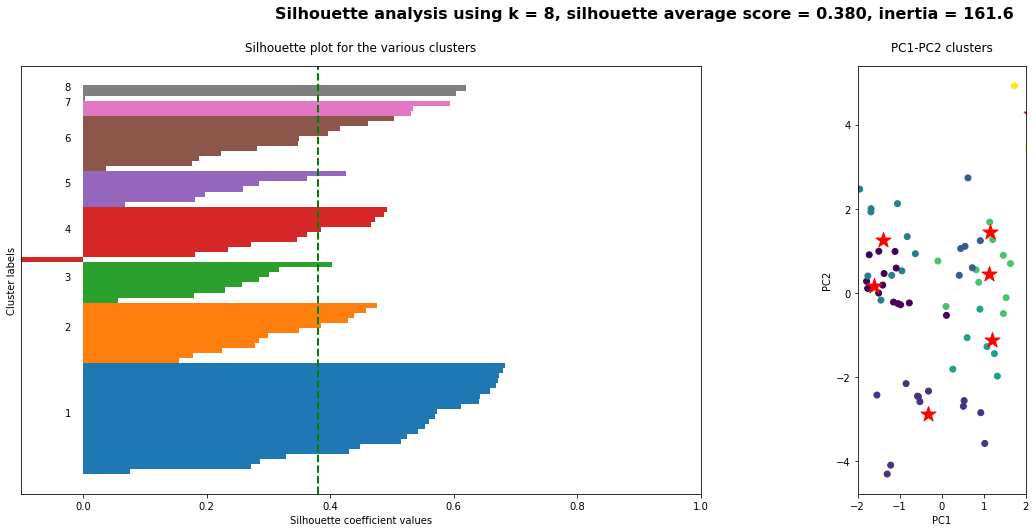

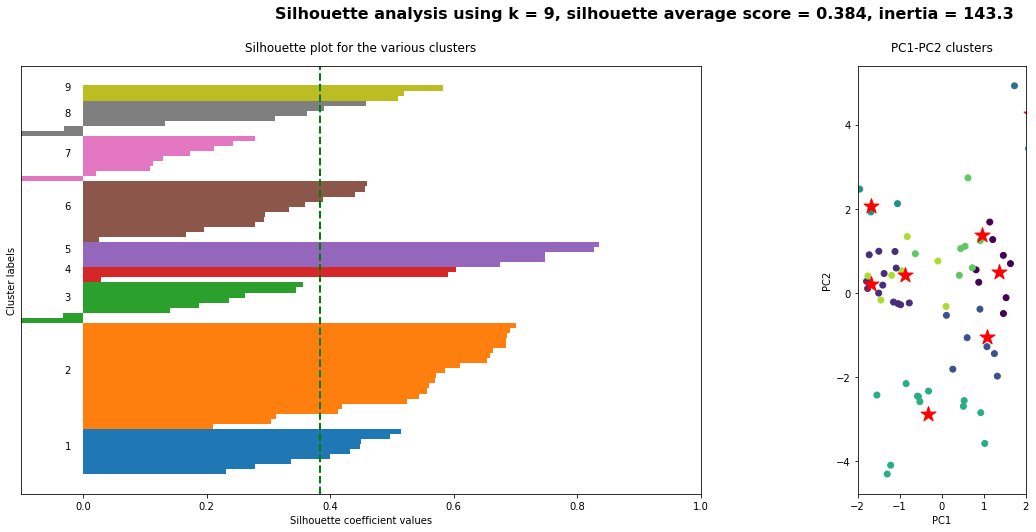

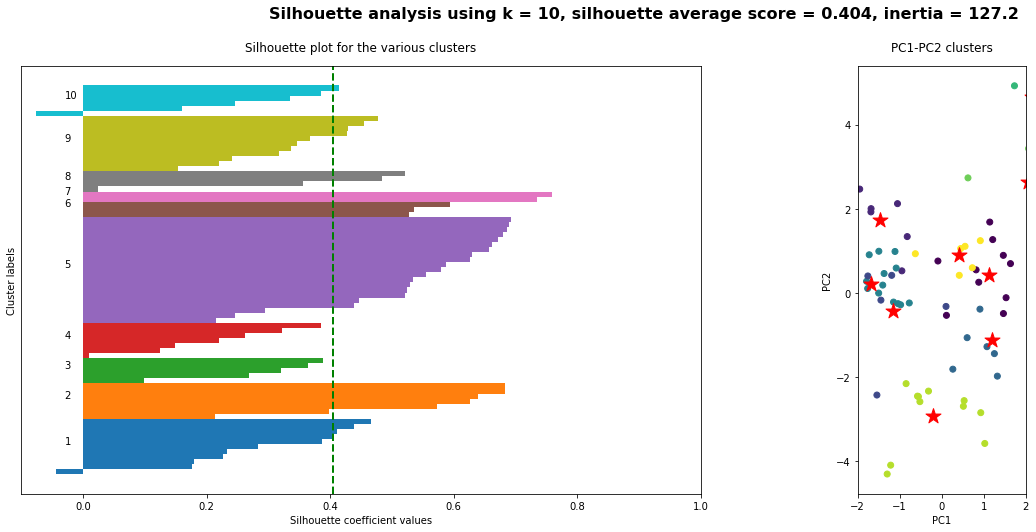

<IPython.core.display.Javascript object>

In [32]:
SAN = [2, 3, 4, 5, 6, 7, 8, 9, 10]

df_eval = run_silhouette_analysis(
    df_red4,
    cols_for_clustering,
    centroids_list=centroids_list,
    df_eval=df_eval,
    SAN=SAN,
)

df_eval

## Cluster the data [Juraj]
* Using K-Means (Univariate, Multivariate)
* Evaluate quality of the clustering (inertia)
* Visualize the clustering